In [7]:
from __future__ import division
%matplotlib inline
# import, do some set up
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import keras as ks
from scipy import linalg as LA
from PIL import Image
import matplotlib.pyplot as plt
from itertools import product
import time

In [8]:
dim = 10

In [9]:
class UFarray:
    def __init__(self):
        self.P = []
        self.label = 0
        
    def makeLabel(self):
        r = self.label
        self.label += 1
        self.P.append(r)
        return r

    def setRoot(self, i, root):
        while self.P[i] < i:
            j = self.P[i]
            self.P[i] = root
            i = j
        self.P[i] = root

    def findRoot(self, i):
        while self.P[i] < i:
            i = self.P[i]
        return i
    
    def find(self, i):
        root = self.findRoot(i)
        self.setRoot(i, root)
        return root
    
    def union(self, i, j):
        if i != j:
            root = self.findRoot(i)
            rootj = self.findRoot(j)
            if root > rootj: root = rootj
            self.setRoot(j, root)
            self.setRoot(i, root)
    
    def flatten(self):
        for i in range(1, len(self.P)):
            self.P[i] = self.P[self.P[i]]
    
    def flattenL(self):
        k = 1
        for i in range(1, len(self.P)):
            if self.P[i] < i:
                self.P[i] = self.P[self.P[i]]
            else:
                self.P[i] = k
                k += 1

def pca(data, dim = 4):
    nPCs = dim
    X = np.double(np.reshape(data , (data.shape[0]*data.shape[1] , data.shape[2])))
    mu = np.mean(X,axis=0)
    for i in range(data.shape[2]):
        X[:,i] = X[:,i] - mu[i]
    v = np.cov(X.T)
    eig_vals, eig_vecs = np.linalg.eig(v)
    img = np.zeros([data.shape[0], data.shape[1], dim], dtype=np.double)
    for i in range(nPCs):
        img[:,:,i] = np.reshape(np.matmul(X,eig_vecs[:,i]), (data.shape[0], data.shape[1]))
    return img

def reshape_to_input_format(input_):
    tmp = np.zeros([1,dim,1])
    for i in range(input_.shape[0]):
        tmp[0][i][0] = input_[i]
    return tmp

def loadData(image):

    if image is 1:
        a = sio.loadmat('DataSet/San_Diego.mat')
    elif image is 2:
        a = sio.loadmat('DataSet/Airport.mat')
    elif image is 3:
        a = sio.loadmat('DataSet/Beach.mat')
    elif image is 4:
        a = sio.loadmat('DataSet/Urban.mat')
    elif image is 5:
        a = sio.loadmat('DataSet/HYDICE_urban.mat')
    elif image is 6:
        a = sio.loadmat('DataSet/Sand.mat')
    data = a['data']
    labels = a['map']
    return data, labels

def dual_window(data, row, col, window_in, window_out):
    total = 0
    h, w, deepth = data.shape
    for i in range(-np.int32(window_out/2), np.int32(window_out/2) + 1):
        for j in range(-np.int32(window_out/2), np.int32(window_out/2) + 1):
            
            if -np.int32(window_in/2) <= i <= np.int32(window_in/2) and -np.int32(window_in/2) <= j <= np.int32(window_in/2):
                continue
            r = row + i
            c = col + j
            
            if r<0 or r>=h:
                continue
            if c<0 or c>=w:
                continue
            total += 1
            
    res = np.zeros((total,1,deepth,1))
    index = 0
    
    for i in range(-np.int32(window_out/2), np.int32(window_out/2) + 1):
        for j in range(-np.int32(window_out/2), np.int32(window_out/2) + 1):
            
            if -np.int32(window_in/2) <= i <= np.int32(window_in/2) and -np.int32(window_in/2) <= j <= np.int32(window_in/2):
                continue
            
            r = row + i
            c = col + j
            
            if r<0 or r>=h:
                continue
            if c<0 or c>=w:
                continue
                
            res[index,0,:,0] = np.abs(data[row, col, :] - data[r, c, :])
            index += 1
    return res

def toBinary(data,th):
    r,c = data.shape
    res = np.zeros((r,c))
    for i in range(r):
        for j in range(c):
            if data[i][j] > th:
                res[i][j] = 1
    return res

In [10]:
# read image and apply pca
img,label = loadData(2)
img = pca(img,dim)
#-- normalize data --
img -= np.amin(img)
img = img / np.amax(img)
img *= 255
img = np.int16(img)
#--------------------

In [11]:
model = ks.models.load_model("mModel.h5")

computational time : 31.216068744659424


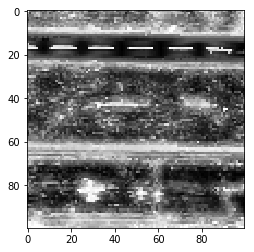

In [12]:
data = np.zeros((img.shape[0],img.shape[1]))
ts = time.time()
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        d = 1 - np.mean(model.predict(dual_window(img,i,j,3,7)))
        data[i,j] = d
testtime = time.time()-ts
print("computational time : " + str(testtime))        
plt.imshow(data,cmap='gray')

In [13]:
sio.savemat('networkoutput', mdict={'res': data})

In [14]:
mdata = toBinary(data,0.65)

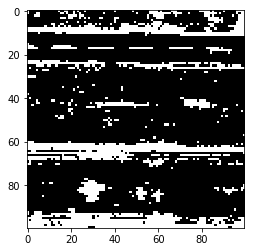

In [16]:
sio.savemat('binaryoutput', mdict={'res': mdata})
plt.imshow(mdata,cmap='gray')

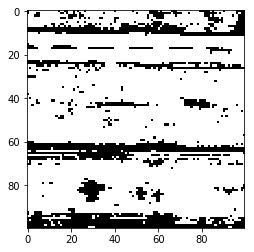

In [17]:
width,height = mdata.shape
o = np.ones([width,height])
mdata = o - mdata
plt.imshow(mdata,cmap='gray')

total computational time : 31.242053270339966


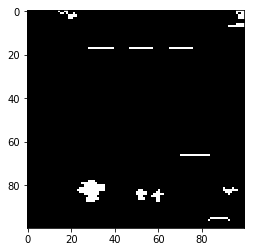

In [20]:
uf = UFarray()
labels = {}
ts = time.time()
for y, x in product(range(height), range(width)):

    if mdata[x, y] == 1:
        pass

    elif y > 0 and mdata[x, y-1] == 0:
        labels[x, y] = labels[(x, y-1)]

    elif x+1 < width and y > 0 and mdata[x+1, y-1] == 0:

        c = labels[(x+1, y-1)]
        labels[x, y] = c

        if x > 0 and mdata[x-1, y-1] == 0:
            a = labels[(x-1, y-1)]
            uf.union(c, a)

        elif x > 0 and mdata[x-1, y] == 0:
            d = labels[(x-1, y)]
            uf.union(c, d)

    elif x > 0 and y > 0 and mdata[x-1, y-1] == 0:
        labels[x, y] = labels[(x-1, y-1)]

    elif x > 0 and mdata[x-1, y] == 0:
        labels[x, y] = labels[(x-1, y)]

    else: 
        labels[x, y] = uf.makeLabel()

# uf.flatten()
out = np.zeros([width, height])
cs = {}

for m in range(uf.label):
    cs[m] = 0

for (x, y) in labels:
    cs[labels[(x,y)]] += 1

for (x, y) in labels:
    if 9< cs[labels[(x, y)]] < 18 or 50 < cs[labels[(x, y)]] < 70:
#       if 22< cs[labels[(x, y)]]:
#      if 17< cs[labels[(x, y)]] < 40 or 55< cs[labels[(x, y)]] < 58 or 95< cs[labels[(x, y)]] < 105:
#         component = uf.find(labels[(x, y)])
#         labels[(x, y)] = component
        out[x, y] = 1
print("total computational time : "+str(time.time()-ts+testtime))
plt.imshow(out,cmap='gray')

In [21]:
sio.savemat('OAFoutput', mdict={'res': out})

In [22]:
sio.savemat('finalresult', mdict={'res': out*data})